In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import time
import os

from monodepthloss import MonodepthLoss
from depthnet import *

#from depthencoder import depthencoder 
#from depth_decoder import *

DEVICE = torch.device("cuda:0")

In [2]:
encoderdecoder = ResnetModel(3).to(DEVICE)

optimizer = optim.Adam(encoderdecoder.parameters(),lr=0.001)
loss_function = MonodepthLoss(n=4, SSIM_w=0.85,\
                disp_gradient_w=0.1, lr_w=1).to(DEVICE)

#encoderdecoder.load_state_dict(torch.load('encoderdecoder-1573856141'))
data = []
directory = "numpy_img/"
for file in os.listdir(directory):
    training_data = np.load(directory+file, allow_pickle=True, mmap_mode = 'r+')
    data.append(training_data)

In [3]:
testing = False
j = 0
mean = []
n = 12
epochs = 10

f= open(f"logs/results-{int(time.time())}.txt","w+")
for epoch in range(epochs):
    samps = []
    print("Epoch: "+ str(epoch))
    for img, training_data in enumerate(data):
        nums = list(range(len(training_data)))
        for i in range(0, len(nums), n):
            set = nums[i:i+n]
            random.shuffle(set)
            samps.append([img, nums[i:i+n]])
    random.shuffle(samps)
    for frame in tqdm(samps):
        LinNimg = torch.from_numpy(data[frame[0]][frame[1],0])\
        .type(torch.cuda.FloatTensor)
        RoutNimg = torch.from_numpy(data[frame[0]][frame[1],1])\
        .type(torch.cuda.FloatTensor)

        LinN = torch.div(LinNimg, 255).permute(0,3,1,2)
        RoutN = torch.div(RoutNimg, 255).permute(0,3,1,2)

        encoderdecoder.zero_grad()
        output = encoderdecoder(LinN.view(-1,3,256,640))
        loss = loss_function(output,[LinN.view(-1,3,256,640),RoutN.view(-1,3,256,640)])
        loss.backward()
        mean.append(loss.item())
        j += 1
        if j % 100 == 0:
            f.write(f"{round(sum(mean)/len(mean),5)}\n")
            f.flush()
            mean = []
        if j % 5000 == 0:
            thetime = int(time.time())
            torch.save(encoderdecoder.state_dict(), f"state_dicts/encoderdecoder-{thetime}")
            save_image(RoutN[1,:,:,:].view(3,256,640).cpu(), \
                       f'imageout/{thetime}-left.png')
            save_image(output[0][1,0,:,:].view(256,640).cpu(), \
                       f'imageout/{thetime}-depth.png')
        optimizer.step()
f.close()

100%|██████████| 11277/11277 [2:51:00<00:00,  1.10it/s]
Epoch: 4
100%|██████████| 11277/11277 [2:51:45<00:00,  1.09it/s]


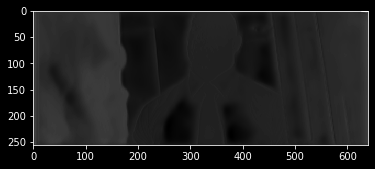

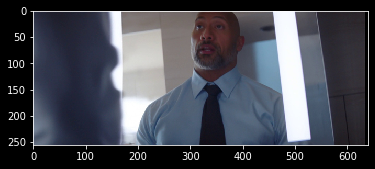

In [10]:
plt.imshow(output[0][0,0,:,:].view(256, 640).cpu().detach().numpy(), 'gray')
plt.show()
plt.imshow(RoutN[0,:,:,:].view(3,256,640).permute(1,2,0).cpu())
plt.show()

In [13]:
output[0][1,0,128,:]

tensor([ 4.6821e-03,  8.8009e-03,  1.1214e-02,  1.2013e-02,  1.4905e-02,
         1.5790e-02,  9.3032e-03,  3.6985e-03,  5.5355e-03,  6.3687e-03,
         8.2954e-03,  6.0108e-03,  2.8307e-03,  1.0847e-03,  2.0020e-04,
        -3.1410e-04, -5.6371e-04, -6.8045e-04, -6.7327e-04, -7.9148e-04,
        -8.5542e-04, -9.8180e-04, -1.0894e-03, -1.1465e-03, -1.2234e-03,
        -1.3061e-03, -1.4469e-03, -1.5770e-03, -1.8128e-03, -2.1537e-03,
        -2.5313e-03, -3.0485e-03, -3.8053e-03, -4.7051e-03, -5.7353e-03,
        -6.7537e-03, -7.9243e-03, -9.1829e-03, -1.0328e-02, -1.1449e-02,
        -1.2639e-02, -1.3700e-02, -1.4541e-02, -1.5154e-02, -1.5477e-02,
        -1.5638e-02, -1.5624e-02, -1.5402e-02, -1.4969e-02, -1.4415e-02,
        -1.3807e-02, -1.3117e-02, -1.2369e-02, -1.1576e-02, -1.0741e-02,
        -9.9438e-03, -9.1524e-03, -8.3216e-03, -7.5634e-03, -6.8106e-03,
        -6.0328e-03, -5.2907e-03, -4.5393e-03, -3.7270e-03, -2.9745e-03,
        -2.1805e-03, -1.4052e-03, -6.8671e-04,  7.6